In [1]:
import numpy as np
from scipy.optimize import nnls

class Result(object):
    '''Result object for storing input and output data for omp.  When called from 
    `omp`, runtime parameters are passed as keyword arguments and stored in the 
    `params` dictionary.
    Attributes:
        X:  Predictor array after (optional) standardization.
        y:  Response array after (optional) standarization.
        ypred:  Predicted response.
        residual:  Residual vector.
        coef:  Solution coefficients.
        active:  Indices of the active (non-zero) coefficient set.
        err:  Relative error per iteration.
        params:  Dictionary of runtime parameters passed as keyword args.   
    '''
    
    def __init__(self, **kwargs):
        
        # to be computed
        self.X = None
        self.y = None
        self.ypred = None
        self.residual = None
        self.coef = None
        self.active = None
        self.err = None
        
        # runtime parameters
        self.params = {}
        for key, val in kwargs.items():
            self.params[key] = val
            
    def update(self, coef, active, err, residual, ypred):
        '''Update the solution attributes.
        '''
        self.coef = coef
        self.active = active
        self.err = err
        self.residual = residual
        self.ypred = ypred

def somp(X, y, nonneg=True, ncoef=None, maxit=200, tol=1e-3, ztol=1e-12, verbose=True):
    '''Compute sparse orthogonal matching pursuit solution with unconstrained
    or non-negative coefficients.
    
    Args:
        X: Dictionary array of size n_samples x n_features. 
        y: Reponse array of size n_samples x 1.
        nonneg: Enforce non-negative coefficients.
        ncoef: Max number of coefficients.  Set to n_features/2 by default.
        tol: Convergence tolerance.  If relative error is less than
            tol * ||y||_2, exit.
        ztol: Residual covariance threshold.  If all coefficients are less 
            than ztol * ||y||_2, exit.
        verbose: Boolean, print some info at each iteration.
        
    Returns:
        result:  Result object.  See Result.__doc__
    '''
    
    def norm2(x):
        return np.linalg.norm(x) / np.sqrt(len(x))
    
    # initialize result object
    result = Result(nnoneg=nonneg, ncoef=ncoef, maxit=maxit,
                    tol=tol, ztol=ztol)
    if verbose:
        print(result.params)
    
    # check to see if we have the same number of X and y inputs
    if len(X) != len(y):
        print('Must have equal number of X and y inputs')
        return result
    # set n = number of inputs
    n = len(y)
    
    # check that n_samples match
    for i in range(n):
        if X[i].shape[0] != len(y[i]):
            print('X and y must have same number of rows (samples)')
            return result
    
    # check types, try to make somewhat user friendly
    for i,item in enumerate(X):
        if type(item) is not np.ndarray:
            X[i] = np.array(item)
    for i,item in enumerate(y):
        if type(item) is not np.ndarray:
            y[i] = np.array(item)
    
    # store arrays in result object    
    result.y = y
    result.X = X
    
    # for rest of call, want y to have ndim=1
    for i,item in enumerate(y):
        if np.ndim(item) > 1:
            y[i] = np.reshape(item, (len(item),))
        
    # by default set max number of coef to half of total possible
    if ncoef is None:
        ncoef = int(X[0].shape[1]/2)
    
    # initialize things
    X_transpose = []
    for x in X:
        X_transpose.append(x.T)               # store for repeated use
    #active = np.array([], dtype=int)         # initialize list of active set
    active = []
    # coef are the output vectors. 1 vector for each input pair given
    coef = []
    for i in range(n):
        coef.append(np.zeros(X[0].shape[1], dtype=float)) # solution vector
    residual = y                             # residual vector
    
    ypred = []
    for i in range(n):
        ypred.append(np.zeros(y[0].shape, dtype=float))
    
    #### Revisit ####
    # How to deal with ynorm and err?
    # err = Min of all ynorm? Max of all ynorm? Avg of all ynorm? Maybe take linear comb of all y and then find ynorm from that?
    ynorm = []
    for i in range(n):
        ynorm.append(norm2(y[i]))                         # store for computing relative err
    ynorm = np.mean(ynorm)
    err = np.zeros(maxit, dtype=float)       # relative err vector
    
    # Check if response has zero norm, because then we're done. This can happen
    # in the corner case where the response is constant and you normalize it.
    if ynorm < tol:     # the same as ||residual|| < tol * ||residual||
        print('Norm of the response is less than convergence tolerance.')
        result.update(coef, active, err[0], residual, ypred)
        return result
    
    # convert tolerances to relative
    tol = tol * ynorm       # convergence tolerance
    ztol = ztol * ynorm     # threshold for residual covariance
    
    if verbose:
        print('\nIteration, relative error, number of non-zeros')
   
    # main iteration
    for it in range(maxit):
        
        # compute residual covariance vector and check threshold
        ##### introduce linear combination into this step for S-OMP #####
        if nonneg:
            rcov = np.dot(X_transpose[0], residual[0])
            for i in range(1,len(y)):
                rcov += np.dot(X_transpose[i], residual[i])
            i = np.argmax(rcov)
            rc = rcov[i]
        else:
            rcov = np.abs(np.dot(X_transpose[0], residual[0]))
            for i in range(1,len(y)):
                rcov += np.abs(np.dot(X_transpose[i], residual[i]))
            i = np.argmax(rcov)
            rc = np.abs(rcov[i])
        if rc < ztol:
            print('All residual covariances are below threshold.')
            break
        
        # update active set
        if i not in active:
            #active = np.concatenate([active, [i]], axis=1)
            active.append(i)
            
        # solve for new coefficients on active set
        # _ are varaibles that don't matter we only care about coefi
        for i in range(n):
            if nonneg:
                coefi, _ = nnls(X[i][:, active], y[i])
            else:
                coefi, _, _, _ = np.linalg.lstsq(X[i][:, active], y[i],rcond=None)
            coef[i][active] = coefi   # update solution
        
        # update residual vector and error
        for i in range(n):
            residual[i] = y[i] - np.dot(X[i][:,active], coefi)
            ypred[i] = y[i] - residual[i]
        ##### Revisit #####
        # same issue as ynorm, how do we deal with error?
        # err = Min of all residual? Max of all residual? 
        # err = Avg of all residual? Maybe take linear comb of all residual and then find residualnorm from that?
        resnorm = []
        for i in range(n):
            resnorm.append(norm2(residual[i]))
        resnorm = np.mean(resnorm)
        err[it] = resnorm / ynorm  
        
        # print status
        if verbose:
            print('{}, {}, {}'.format(it, err[it], len(active)))
            
        # check stopping criteria
        if err[it] < tol:  # converged
            print('\nConverged.')
            break
        if len(active) >= ncoef:   # hit max coefficients
            print('\nFound solution with max number of coefficients.')
            break
        if it == maxit-1:  # max iterations
            print('\nHit max iterations.')
    
    result.update(coef, active, err[:(it+1)], residual, ypred)
    return result

if __name__ == '__main__':
    pass

In [20]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from sklearn import preprocessing

n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data

# y = Xw
# |x|_0 = n_nonzero_coefs

y, X, w = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)

(idx,) = w.nonzero()

<StemContainer object of 3 artists>

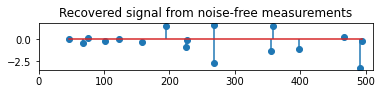

In [10]:
import matplotlib.pyplot as plt

omp1 = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, normalize=False)
omp1.fit(X, y)
coef = omp1.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

{'nnoneg': False, 'ncoef': 17, 'maxit': 200, 'tol': 0.001, 'ztol': 1e-12}

Iteration, relative error, number of non-zeros
0, 0.8321781951648214, 1
1, 0.6346451302338469, 2
2, 0.5612953474294158, 3
3, 0.485941416911541, 4
4, 0.39174529544808073, 5
5, 0.28913526085223745, 6
6, 0.18463178198552954, 7
7, 0.1229197588696176, 8
8, 0.10424460666658457, 9
9, 0.0752729184913353, 10
10, 0.06109754135778676, 11
11, 0.051325460019360156, 12
12, 0.033771193723443615, 13
13, 0.027114811820435073, 14
14, 0.019394556866830705, 15
15, 0.012303389435757985, 16
16, 1.2353577182577664e-16, 17

Converged.


<StemContainer object of 3 artists>

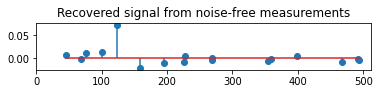

In [56]:
result = omp([X],[y],nonneg = False, ncoef=17)
coef = result.coef
(idx_r,) = coef[0].nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[0][idx_r], use_line_collection=True)